# 03wk-2: 깊은신경망 – 로지스틱의 한계 극복

최규빈  
2024-03-20

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/03wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [ ]:
# {{<video https://youtu.be/playlist?list=PLQqh36zP38-wO_Mc_74QoweAxCWw5A86_&si=iWAgttM-CIgsi1x3 >}}

# 2. Imports

In [1]:
import torch
import matplotlib.pyplot as plt 
import pandas as pd

# 3. 꺽인 그래프를 만드는 방법

`-` 로지스틱의 한계를 극복하기 위해서는 시그모이드를 취하기 전에 꺽인
그래프 모양을 만드는 기술이 있어야겠음.

`-` 아래와 같은 벡터 ${\boldsymbol x}$를 가정하자.

In [13]:
x = torch.linspace(-1,1,1001).reshape(-1,1)
x

`-` 목표: 아래와 같은 벡터 ${\boldsymbol y}$를 만들어보자.

$${\boldsymbol y} = [y_1,y_2,\dots,y_{n}], \quad y_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$$

## A. 방법1

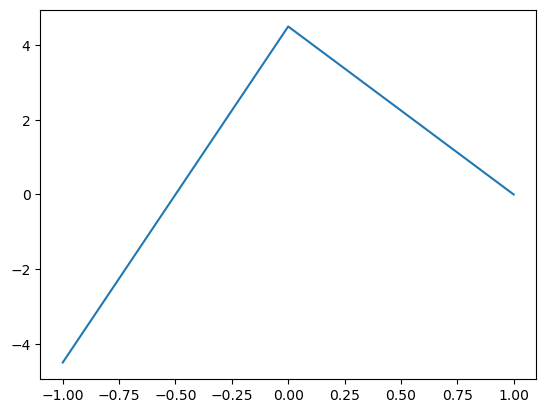

In [22]:
y = x*0
y[x<0] = (9*x+4.5)[x<0]
y[x>0] = (-4.5*x+4.5)[x>0]
plt.plot(x,y)

## B. 방법2 – 렐루이용

In [23]:
relu = torch.nn.ReLU()

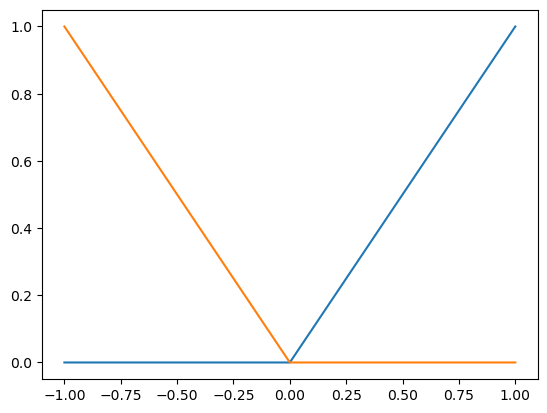

In [28]:
plt.plot(x,relu(x))
plt.plot(x,relu(-x))

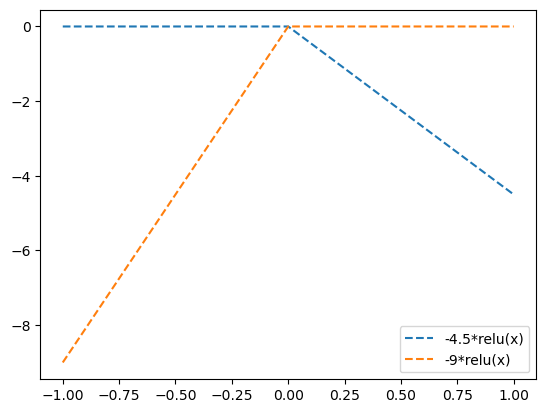

In [31]:
plt.plot(x,-4.5*relu(x),'--',label='-4.5*relu(x)')
plt.plot(x,-9*relu(-x),'--',label='-9*relu(x)')
plt.legend()

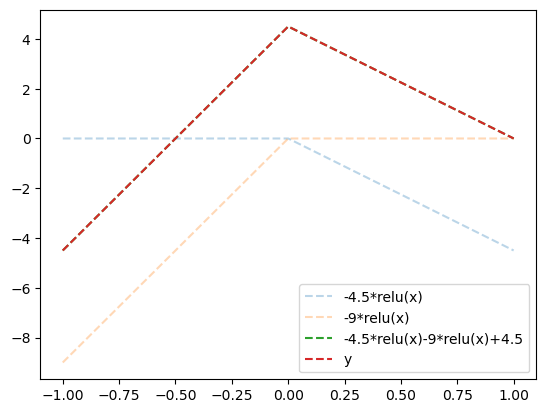

In [36]:
plt.plot(x,-4.5*relu(x),'--',label='-4.5*relu(x)',alpha=0.3)
plt.plot(x,-9*relu(-x),'--',label='-9*relu(x)',alpha=0.3)
plt.plot(x,-4.5*relu(x)-9*relu(-x)+4.5,'--',label='-4.5*relu(x)-9*relu(x)+4.5')
plt.plot(x,y,'--',label='y')
plt.legend()

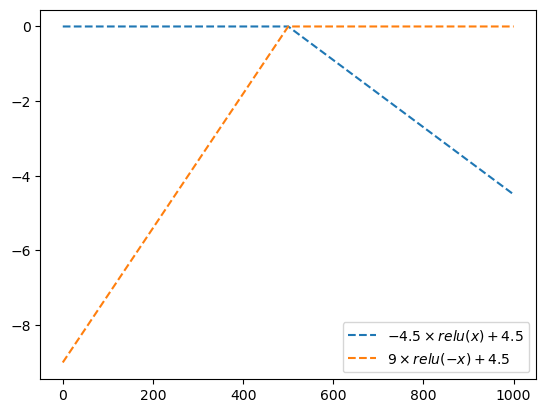

In [8]:
#

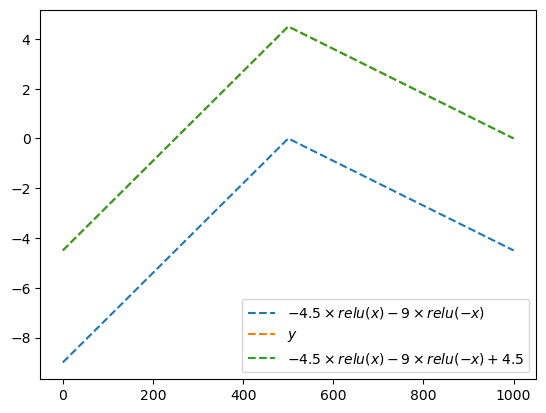

In [9]:
#

`-` 우리의 목표: 저 초록선에서 시그모이드를 태우면된다. 즉 아래의 느낌임

In [51]:
sig = torch.nn.Sigmoid()

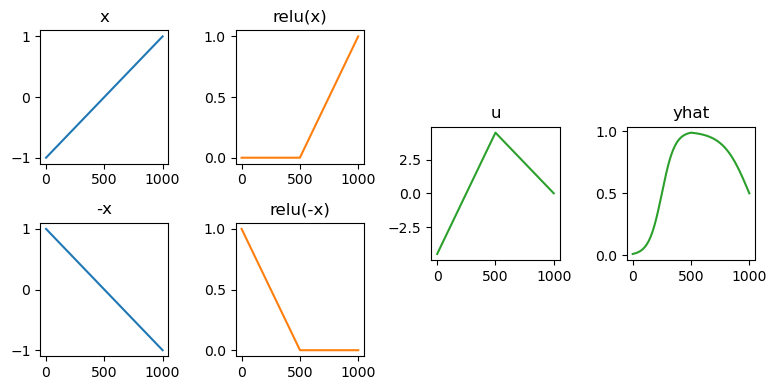

In [53]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title('x')
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title('-x')
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title('relu(x)')
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title('relu(-x)')
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title('u')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('yhat');
#---#
ax1.plot(x,color="C0")
ax2.plot(-x,color="C0")
ax3.plot(relu(x),color="C1")
ax4.plot(relu(-x),color="C1")
ax5.plot(-4.5*relu(x)-9.0*relu(-x)+4.5,color="C2")
ax6.plot(sig(-4.5*relu(x)-9.0*relu(-x)+4.5),color="C2")
fig.tight_layout()

## C. 방법2의 다른구현

`-` 렐루이용하여 만드는 방법 정리

1.  벡터 x와 relu함수를 준비한다.
2.  u = \[x,-x\] 를 계산한다.
3.  v = \[relu(x), relu(-x)\] 를 계산한다.
4.  y = -4.5 \* relu(x) - 9 \* relu(-x) +4.5 를 계산한다.

`-` 1단계

In [54]:
x,relu

`-` 2단계

In [61]:
u = torch.concat([x,-x],axis=1)
u

`-` 3단계

In [64]:
v = relu(u)
v

`-` 4단계

In [68]:
v[:,[0]] * -4.5 + v[:,[1]] * -9.0 + 4.5 

In [69]:
y

`-` 그런데, 4단계는 아래와 같이 볼 수 있다.

-   ${\boldsymbol v}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix} v_{11} & v_{12} \\ v_{21} & v_{22} \\ \dots & \dots \\ v_{n1} & v_{n2} \\ \end{bmatrix}\begin{bmatrix} -4.5 \\ -9.0 \end{bmatrix} + 4.5 = \begin{bmatrix} -4.5 v_{11} - 9.0 v_{12} + 4.5 \\ -4.5 v_{21} - 9.0 v_{22} + 4.5 \\ \dots \\ -4.5 v_{n1} - 9.0 v_{n2} + 4.5 \\ \end{bmatrix}$

위의 수식을 참고하여 매트릭스의 곱 형태로 다시 포현하면 아래와 같다.

In [73]:
What = torch.tensor([[-4.5],[-9.0]])
v @ What + 4.5 

In [74]:
y

이제 매트릭스의 곱 대신에 `torch.nn.Linear()`를 이용하면 아래의 코드와
같아진다.

In [85]:
#v --> y 
l2 = torch.nn.Linear(
    in_features=2,
    out_features=1
)
l2.weight.data = torch.tensor([[ -4.5, -9.0]])
l2.bias.data = torch.tensor([4.5])
l2(v)

In [86]:
y

`-` 사실 2단계도 아래와 같이 볼 수 있다.

$$\begin{bmatrix}
x_1 \\
x_2 \\
\dots \\ 
x_n 
\end{bmatrix}\begin{bmatrix} 1 & -1 \end{bmatrix} = \begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n \end{bmatrix}$$

In [91]:
l1 = torch.nn.Linear(
    in_features=1,
    out_features=2
)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,  0.0])
l1(x)

`-` 따라서 `torch.nn` 에 포함된 레이어를 이용하면 아래와 같이 표현할 할
수 있다.

In [96]:
l1 = torch.nn.Linear(1,2)
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(2,1)
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])

In [97]:
l2(a1(l1(x))), y

`-` 각각의 layer를 `torch.nn.Sequential()` 로 묶으면 아래와 같이 구현할
수 있다.

In [99]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1)
)
l1, a1, l2 = net
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0,0.0])
l2.weight.data = torch.tensor([[-4.5,-9.0]])
l2.bias.data = torch.tensor([4.5])
net(x),y

## D. 수식표현

`(1)` ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$

`(2)`
$l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\ x_n & -x_n\end{bmatrix}$

-   ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
-   ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$

`(3)`
$(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\ \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$

`(4)`
$(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$

$\quad=\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

-   ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
-   $b^{(2)}=4.5$

`(5)`
$net({\bf X})=(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}$

$\quad =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$

# 4. 로지스틱의 한계 극복

## A. 데이터

In [100]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2024/main/posts/dnnex.csv")
df

In [102]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)
prob = torch.tensor(df.prob).float().reshape(-1,1)

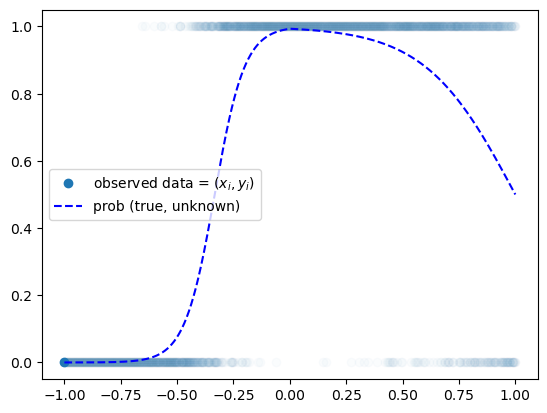

In [103]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.legend()

## B. Step 1~4

`-` Step1에 대한 생각: 네트워크를 어떻게 만들까? = 아키텍처를 어떻게
만들까? = 모델링

$$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$$

`-` Step2,3,4 는 너무 뻔해서..

In [118]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(1,2),
    torch.nn.ReLU(),
    torch.nn.Linear(2,1),
    torch.nn.Sigmoid(),
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())
#---#
for epoc in range(3000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

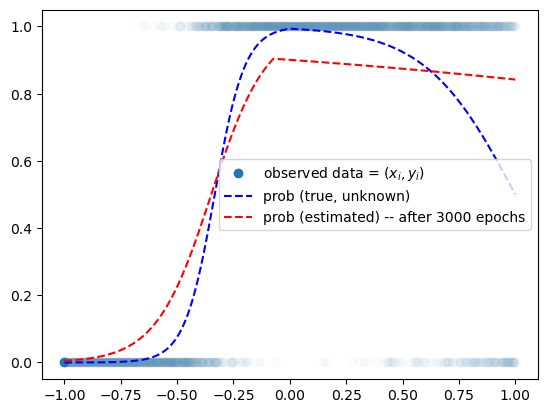

In [120]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--r',label= r"prob (estimated) -- after 3000 epochs")
plt.legend()

In [121]:
for epoc in range(3000):
    ## 1 
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

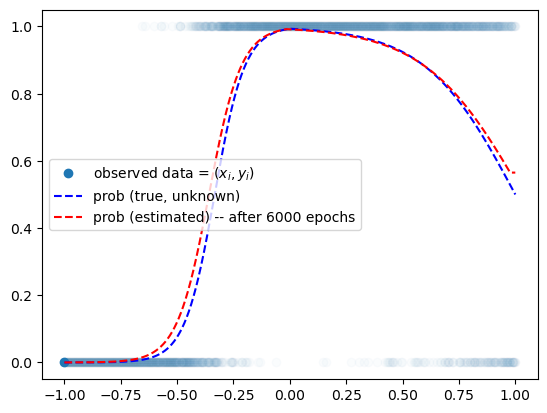

In [122]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x[0],y[0],'o',label= r"observed data = $(x_i,y_i)$",color="C0")
plt.plot(x,prob,'--b',label= r"prob (true, unknown)")
plt.plot(x,net(x).data,'--r',label= r"prob (estimated) -- after 6000 epochs")
plt.legend()